In [9]:
import pandas as pd

df = pd.read_pickle('../data/final_preprocessed_dataset.pkl')


In [10]:
print(df.columns.tolist())


['gender', 'height', 'weight', 'ap_hi', 'ap_lo', 'cholesterol', 'gluc', 'smoke', 'alco', 'active', 'cardio', 'Chronological_Age', 'BMI', 'Pulse_Pressure', 'MAP', 'SBP_DBP_Ratio', 'Obesity_Class', 'Lifestyle_Risk', 'height_scaled', 'weight_scaled', 'ap_hi_scaled', 'ap_lo_scaled', 'BMI_scaled', 'MAP_scaled', 'Pulse_Pressure_scaled', 'SBP_DBP_Ratio_scaled', 'Obesity_Class_Encoded']


In [11]:
df.head()

,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,...,Lifestyle_Risk,height_scaled,weight_scaled,ap_hi_scaled,ap_lo_scaled,BMI_scaled,MAP_scaled,Pulse_Pressure_scaled,SBP_DBP_Ratio_scaled,Obesity_Class_Encoded
0,2,168,62.0,110,80,1,1,0,0,1,...,0,0.444260,-0.846040,-0.994279,-0.143159,-0.918170,-0.584720,-1.272755,-1.241263,1
1,1,156,85.0,140,90,3,1,0,0,1,...,0,-1.021866,0.758864,0.799712,0.906792,1.223691,0.925888,0.394973,-0.035083,4
2,1,165,64.0,130,70,3,1,0,0,0,...,1,0.077729,-0.706483,0.201715,-1.193111,-0.663556,-0.584720,1.228837,1.979636,1
3,2,169,82.0,150,100,1,1,0,0,1,...,0,0.566437,0.549529,1.397709,1.956743,0.196237,1.832253,0.394973,-0.406215,2
4,1,156,56.0,100,60,1,1,0,0,0,...,1,-1.021866,-1.264711,-1.592276,-2.243062,-0.745629,-2.095328,-0.438891,0.707182,1


In [12]:
#Binary Classification
df['HighChol_Flag'] = (df['cholesterol'] > 1).astype(int)
df['HighGluc_Flag'] = (df['gluc'] > 1).astype(int)


In [13]:
df['Obesity_Class_Encoded'] = df['Obesity_Class'].astype('category').cat.codes


In [14]:
# Target variable
y = df['Chronological_Age']

# Feature groups
scaled_features = ['height_scaled', 'weight_scaled', 'ap_hi_scaled', 'ap_lo_scaled', 
                   'BMI_scaled', 'MAP_scaled', 'Pulse_Pressure_scaled', 'SBP_DBP_Ratio_scaled']

raw_features = ['height', 'weight', 'ap_hi', 'ap_lo', 'BMI', 'MAP', 'Pulse_Pressure', 'SBP_DBP_Ratio']

binary_features = ['gender', 'smoke', 'alco', 'active', 'cardio', 'HighChol_Flag', 'HighGluc_Flag', 'Lifestyle_Risk']
categorical_encoded = ['Obesity_Class_Encoded']  # ordinal encoding for trees

# One-hot encode Obesity_Class for linear models
df_linear = pd.get_dummies(df, columns=['Obesity_Class'], drop_first=True)


In [15]:
from sklearn.model_selection import train_test_split
# Final feature sets
X_linear = df_linear[scaled_features + binary_features + 
                     [col for col in df_linear.columns if col.startswith("Obesity_Class_")]]

X_tree = df[raw_features + binary_features + categorical_encoded]

# Train/test split
X_train_linear, X_test_linear, y_train, y_test = train_test_split(X_linear, y, test_size=0.2, random_state=42)
X_train_tree, X_test_tree, y_train_tree, y_test_tree = train_test_split(X_tree, y, test_size=0.2, random_state=42)


In [16]:
%pip install xgboost lightgbm


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [17]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import pandas as pd

# Models categorized by feature type
linear_models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(alpha=1.0),
    'Lasso Regression': Lasso(alpha=0.01)
}

tree_models = {
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'AdaBoost': AdaBoostRegressor(n_estimators=100, random_state=42),
    'XGBoost': XGBRegressor(n_estimators=100, random_state=42, verbosity=0),
    'LightGBM': LGBMRegressor(n_estimators=100, random_state=42)
}

# Results container
all_results = []

# Evaluate linear models using scaled & one-hot features
for name, model in linear_models.items():
    model.fit(X_train_linear, y_train)
    y_pred = model.predict(X_test_linear)

    all_results.append({
        'Model': name,
        'MAE': mean_absolute_error(y_test, y_pred),
        'RMSE': np.sqrt(mean_squared_error(y_test, y_pred)),
        'R²': r2_score(y_test, y_pred)
    })

# Evaluate tree-based models using raw + binary + ordinal features
for name, model in tree_models.items():
    model.fit(X_train_tree, y_train)
    y_pred = model.predict(X_test_tree)

    all_results.append({
        'Model': name,
        'MAE': mean_absolute_error(y_test, y_pred),
        'RMSE': np.sqrt(mean_squared_error(y_test, y_pred)),
        'R²': r2_score(y_test, y_pred)
    })

# Final model comparison table
comparison_df = pd.DataFrame(all_results).set_index('Model').sort_values('RMSE')
print("📊 Full Model Comparison:\n")
print(comparison_df.round(4))


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003301 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1109
[LightGBM] [Info] Number of data points in the train set: 54976, number of used features: 17
[LightGBM] [Info] Start training from score 52.790254
📊 Full Model Comparison:

                      MAE    RMSE      R²
Model                                    
LightGBM           5.3327  6.4396  0.1063
Linear Regression  5.4062  6.5066  0.0876
Ridge Regression   5.4066  6.5072  0.0874
Lasso Regression   5.4083  6.5083  0.0871
XGBoost            5.3789  6.5097  0.0867
AdaBoost           5.5820  6.6365  0.0508
Random Forest      5.7076  6.9738 -0.0482


In [18]:
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import make_scorer, mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
import pandas as pd
import numpy as np

# 1. Define custom scorers
mae_scorer = make_scorer(mean_absolute_error, greater_is_better=False)
rmse_scorer = make_scorer(lambda y_true, y_pred: np.sqrt(mean_squared_error(y_true, y_pred)), greater_is_better=False)
r2_scorer = make_scorer(r2_score)

# 2. Define 5-fold CV strategy
cv = KFold(n_splits=5, shuffle=True, random_state=42)

# 3. Separate models by feature type
linear_models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(alpha=1.0),
    'Lasso Regression': Lasso(alpha=0.01)
}

tree_models = {
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'AdaBoost': AdaBoostRegressor(n_estimators=100, random_state=42),
    'XGBoost': XGBRegressor(n_estimators=100, random_state=42, verbosity=0),
    'LightGBM': LGBMRegressor(n_estimators=100, random_state=42)
}

# 4. Evaluate all models with their respective feature sets
cv_results = []

# ➤ Linear models (X_linear: scaled + one-hot encoded)
for name, model in linear_models.items():
    mae = cross_val_score(model, X_linear, y, cv=cv, scoring=mae_scorer)
    rmse = cross_val_score(model, X_linear, y, cv=cv, scoring=rmse_scorer)
    r2 = cross_val_score(model, X_linear, y, cv=cv, scoring=r2_scorer)

    cv_results.append({
        'Model': name,
        'MAE (mean ± std)': f"{abs(mae.mean()):.4f} ± {mae.std():.4f}",
        'RMSE (mean ± std)': f"{abs(rmse.mean()):.4f} ± {rmse.std():.4f}",
        'R² (mean ± std)': f"{r2.mean():.4f} ± {r2.std():.4f}"
    })

# ➤ Tree-based models (X_tree: raw + binary + ordinal)
for name, model in tree_models.items():
    mae = cross_val_score(model, X_tree, y, cv=cv, scoring=mae_scorer)
    rmse = cross_val_score(model, X_tree, y, cv=cv, scoring=rmse_scorer)
    r2 = cross_val_score(model, X_tree, y, cv=cv, scoring=r2_scorer)

    cv_results.append({
        'Model': name,
        'MAE (mean ± std)': f"{abs(mae.mean()):.4f} ± {mae.std():.4f}",
        'RMSE (mean ± std)': f"{abs(rmse.mean()):.4f} ± {rmse.std():.4f}",
        'R² (mean ± std)': f"{r2.mean():.4f} ± {r2.std():.4f}"
    })

# 5. Display final comparison table
cv_df = pd.DataFrame(cv_results).set_index('Model')
print("📊 5-Fold Cross-Validation Comparison for All Models:")
display(cv_df)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003898 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1109
[LightGBM] [Info] Number of data points in the train set: 54976, number of used features: 17
[LightGBM] [Info] Start training from score 52.790254
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002798 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1109
[LightGBM] [Info] Number of data points in the train set: 54977, number of used features: 17
[LightGBM] [Info] Start training from score 52.778889
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003254 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not eno

,MAE (mean ± std),RMSE (mean ± std),R² (mean ± std)
Model,,,
Linear Regression,5.3609 ± 0.0312,6.4667 ± 0.0266,0.0859 ± 0.0027
Ridge Regression,5.3612 ± 0.0310,6.4668 ± 0.0266,0.0859 ± 0.0026
Lasso Regression,5.3631 ± 0.0303,6.4676 ± 0.0264,0.0857 ± 0.0029
Random Forest,5.6575 ± 0.0310,6.9222 ± 0.0301,-0.0474 ± 0.0065
AdaBoost,5.5028 ± 0.0588,6.5598 ± 0.0517,0.0594 ± 0.0086
XGBoost,5.3281 ± 0.0337,6.4610 ± 0.0290,0.0875 ± 0.0030
LightGBM,5.2821 ± 0.0328,6.3915 ± 0.0277,0.1071 ± 0.0036


In [20]:
%pip install statsmodels matplotlib


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [21]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
import pandas as pd
import numpy as np

# Define RMSE scorer (lower is better)
rmse_scorer = make_scorer(lambda y_true, y_pred: np.sqrt(mean_squared_error(y_true, y_pred)), greater_is_better=False)

# Define models by feature type
linear_models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(),
    'Lasso Regression': Lasso(alpha=0.01)
}

tree_models = {
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'AdaBoost': AdaBoostRegressor(n_estimators=100, random_state=42),
    'XGBoost': XGBRegressor(n_estimators=100, random_state=42, verbosity=0),
    'LightGBM': LGBMRegressor(n_estimators=100, random_state=42)
}

# Collect RMSE scores for all models
rmse_scores = []

# ➤ Linear models use X_linear (scaled + one-hot)
for name, model in linear_models.items():
    scores = cross_val_score(model, X_linear, y, cv=5, scoring=rmse_scorer)
    for score in scores:
        rmse_scores.append({'Model': name, 'RMSE': abs(score)})

# ➤ Tree-based models use X_tree (raw + binary + encoded)
for name, model in tree_models.items():
    scores = cross_val_score(model, X_tree, y, cv=5, scoring=rmse_scorer)
    for score in scores:
        rmse_scores.append({'Model': name, 'RMSE': abs(score)})

# Final DataFrame for ANOVA/Tukey
rmse_df = pd.DataFrame(rmse_scores)
print("✅ RMSE Scores Prepared for ANOVA/Tukey:")
display(rmse_df)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003506 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1102
[LightGBM] [Info] Number of data points in the train set: 54976, number of used features: 17
[LightGBM] [Info] Start training from score 52.796020
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003020 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1114
[LightGBM] [Info] Number of data points in the train set: 54977, number of used features: 17
[LightGBM] [Info] Start training from score 52.800990
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003223 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not eno

,Model,RMSE
0,Linear Regression,6.499482
1,Linear Regression,6.492092
2,Linear Regression,6.490467
3,Linear Regression,6.426264
4,Linear Regression,6.420969
5,Ridge Regression,6.498588
6,Ridge Regression,6.492832
7,Ridge Regression,6.491059
8,Ridge Regression,6.427240
9,Ridge Regression,6.421339


In [22]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

# Assuming `rmse_df` has columns: Model, RMSE
anova_model = ols('RMSE ~ C(Model)', data=rmse_df).fit()
anova_table = sm.stats.anova_lm(anova_model, typ=2)

print("📊 ANOVA Results:\n")
print(anova_table)


📊 ANOVA Results:

            sum_sq    df           F        PR(>F)
C(Model)  0.897286   6.0  126.829117  5.639689e-19
Residual  0.033016  28.0         NaN           NaN


In [25]:
import statsmodels.stats.multicomp as mc

tukey = mc.pairwise_tukeyhsd(endog=rmse_df['RMSE'], groups=rmse_df['Model'], alpha=0.05)

print("🔍 Tukey’s HSD Post-hoc Test:\n")
print(tukey)


🔍 Tukey’s HSD Post-hoc Test:

           Multiple Comparison of Means - Tukey HSD, FWER=0.05            
      group1            group2      meandiff p-adj   lower   upper  reject
--------------------------------------------------------------------------
         AdaBoost  Lasso Regression  -0.1043 0.0008 -0.1732 -0.0354   True
         AdaBoost          LightGBM  -0.1812    0.0 -0.2501 -0.1123   True
         AdaBoost Linear Regression  -0.1056 0.0007 -0.1745 -0.0367   True
         AdaBoost     Random Forest   0.3326    0.0  0.2637  0.4015   True
         AdaBoost  Ridge Regression  -0.1053 0.0007 -0.1742 -0.0364   True
         AdaBoost           XGBoost  -0.1198 0.0001 -0.1887 -0.0509   True
 Lasso Regression          LightGBM  -0.0769 0.0212 -0.1458  -0.008   True
 Lasso Regression Linear Regression  -0.0013    1.0 -0.0702  0.0676  False
 Lasso Regression     Random Forest   0.4369    0.0  0.3681  0.5058   True
 Lasso Regression  Ridge Regression   -0.001    1.0 -0.0699  0.0679  F

In [26]:
import matplotlib.pyplot as plt


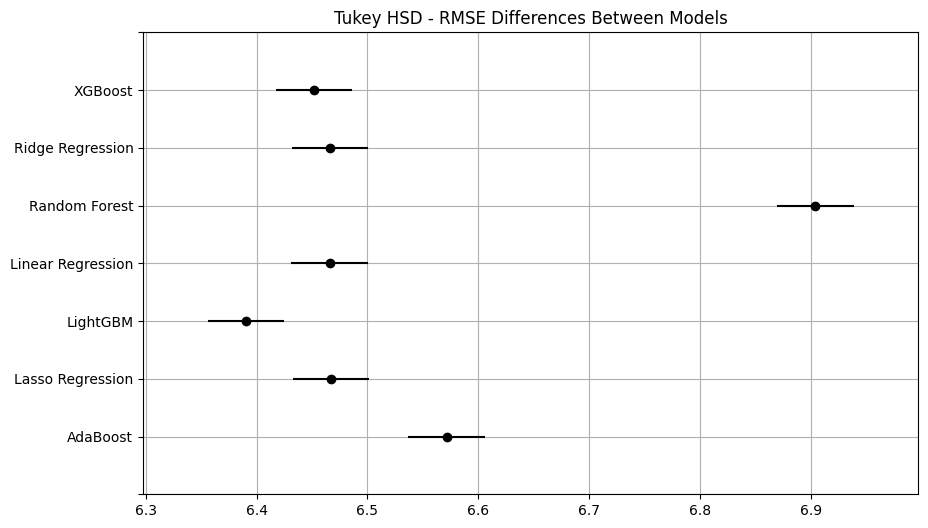

In [27]:
tukey.plot_simultaneous(figsize=(10, 6))
plt.title("Tukey HSD - RMSE Differences Between Models")
plt.grid(True)
plt.show()


In [28]:
%pip install joblib


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [29]:
from lightgbm import LGBMRegressor

# Retrain LightGBM with tree-appropriate features
final_model = LGBMRegressor(n_estimators=100, random_state=42)
final_model.fit(X_train_tree, y_train)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003600 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1109
[LightGBM] [Info] Number of data points in the train set: 54976, number of used features: 17
[LightGBM] [Info] Start training from score 52.790254


LGBMRegressor(random_state=42)

In [31]:
import os
import joblib

# Create the directory if it doesn't exist
os.makedirs('../model', exist_ok=True)

# Now save the model
joblib.dump(final_model, '../model/lightgbm_model.pkl')


['../model/lightgbm_model.pkl']

In [32]:
import os
os.makedirs('model', exist_ok=True)


In [34]:
%pip install shap lime


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [35]:
import joblib

# Save the column names used in the tree-based model
joblib.dump(X_train_tree.columns.tolist(), '../model/feature_columns.pkl')


['../model/feature_columns.pkl']

In [39]:
import joblib
import shap
import pandas as pd
import matplotlib.pyplot as plt  # Required to save the plot

# Load trained LightGBM model
model = joblib.load('../model/lightgbm_model.pkl')

# Load feature columns
feature_columns = joblib.load('../model/feature_columns.pkl')

# Prepare input features
X_input = df[feature_columns]

# Generate SHAP values
explainer = shap.Explainer(model)
shap_values = explainer(X_input)

# Create and save SHAP summary plot
plt.figure()
shap.summary_plot(shap_values, X_input, show=False)
plt.savefig('../static/shap_summary.png', bbox_inches='tight', dpi=300)
plt.close()


In [40]:
import joblib
import shap
import matplotlib.pyplot as plt
import os

# Assumes df is already loaded
model = joblib.load('../model/lightgbm_model.pkl')
feature_columns = joblib.load('../model/feature_columns.pkl')
X = df[feature_columns]

# Create output folder if it doesn't exist
os.makedirs('static', exist_ok=True)

# SHAP Explainer (reuse if already defined)
explainer = shap.Explainer(model)
shap_values = explainer(X)

# 1. Global bar plot (mean absolute SHAP value)
plt.figure()
shap.plots.bar(shap_values, show=False)
plt.savefig('../static/shap_global_bar.png', bbox_inches='tight', dpi=300)
plt.close()

# 2. Local waterfall plot for first row
plt.figure()
shap.plots.waterfall(shap_values[0], show=False)
plt.savefig('../static/shap_local_waterfall.png', bbox_inches='tight', dpi=300)
plt.close()

print("✅ SHAP global bar and local waterfall plots saved in 'static/' folder.")


✅ SHAP global bar and local waterfall plots saved in 'static/' folder.


In [41]:
import joblib
import pandas as pd
import numpy as np
from lime.lime_tabular import LimeTabularExplainer

# Load model
model = joblib.load('../model/lightgbm_model.pkl')



# Load feature columns used for training
feature_columns = joblib.load('../model/feature_columns.pkl')
X = df[feature_columns]

# Initialize LIME explainer
explainer = LimeTabularExplainer(
    training_data=X.values,
    feature_names=X.columns.tolist(),
    mode='regression'
)

# Pick an instance and explain it
instance = X.iloc[0].values
exp = explainer.explain_instance(instance, model.predict)

# Save explanation to HTML
html = exp.as_html()
with open('lime_explanation.html', 'w', encoding='utf-8') as f:
    f.write(html)

print("✅ LIME explanation saved as 'lime_explanation.html'")


✅ LIME explanation saved as 'lime_explanation.html'


C:\Users\Siri\AppData\Roaming\Python\Python312\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


Difference between Chronological and Biological age 

In [42]:
import joblib
import pandas as pd

model = joblib.load('../model/lightgbm_model.pkl')




In [43]:
df['Predicted_Biological_Age'] = final_model.predict(X)


In [44]:
df['Age_Gap'] = df['Predicted_Biological_Age'] - df['Chronological_Age']


In [45]:
df[['Chronological_Age', 'Predicted_Biological_Age', 'Age_Gap']].head()


,Chronological_Age,Predicted_Biological_Age,Age_Gap
0,50,48.770215,-1.229785
1,55,56.003859,1.003859
2,51,54.697167,3.697167
3,48,53.567694,5.567694
4,47,48.527189,1.527189


In [46]:
%matplotlib inline


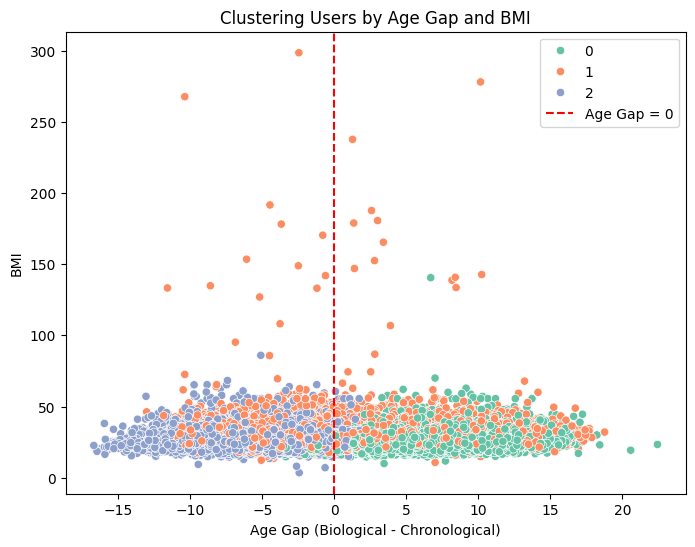

         Age_Gap    BMI     MAP  Lifestyle_Risk
Cluster                                        
0           5.94  26.24   89.48            0.33
1           0.08  29.85  110.05            0.36
2          -4.59  26.81   91.91            0.33


In [47]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

# Select features for clustering
cluster_features = df[['Age_Gap', 'BMI', 'MAP', 'Lifestyle_Risk']]
kmeans = KMeans(n_clusters=3, random_state=42)
df['Cluster'] = kmeans.fit_predict(cluster_features)

# Visualize
plt.figure(figsize=(8,6))
sns.scatterplot(data=df, x='Age_Gap', y='BMI', hue='Cluster', palette='Set2')
plt.axvline(0, color='red', linestyle='--', label='Age Gap = 0')
plt.title('Clustering Users by Age Gap and BMI')
plt.xlabel('Age Gap (Biological - Chronological)')
plt.ylabel('BMI')
plt.legend()
plt.show()

# Optional: Cluster interpretation
print(df.groupby('Cluster')[['Age_Gap', 'BMI', 'MAP', 'Lifestyle_Risk']].mean().round(2))


In [48]:
feature_names_for_clustering = ['Age_Gap', 'BMI', 'MAP', 'Lifestyle_Risk']


In [49]:
joblib.dump(kmeans, '../model/kmeans_model.pkl')
joblib.dump(feature_names_for_clustering, '../model/cluster_features.pkl')


['../model/cluster_features.pkl']